<a href="https://colab.research.google.com/github/ibonetc/Esp_IA/blob/main/Heur%C3%ADstica_AlgoritmosB%C3%BAsqueda/IA_LatLong_InformacionMapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Localización en mapas

Captura de información para poder hacer métodos de rutas

Se debe instalar el paquete osmnx, que permite obtener mapas en un grafo con información de latitud y longitud de diferentes puntos, con sus distancias

In [1]:
!pip install osmnx

In [2]:
!pip install plotly_express

**Nota** : Después de instalar la biblioteca osmnx debe reiniciar el entorno de ejecuación y entonces ejecutar el siguiente código

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
import plotly_express as px

import networkx as nx
import osmnx as ox
#ox.config(use_cache=True, log_console=True)

## Mapa de Envigado

La función **graph_from_place** recibe un texto con la dirección del lugar que se desea buscar, y tiene un parámetro *network_type* para ver cómo se desea obtener el mapa, en nuestro caso que queremos hacer ruts para trayecto en carro escogeremos: 'drive'

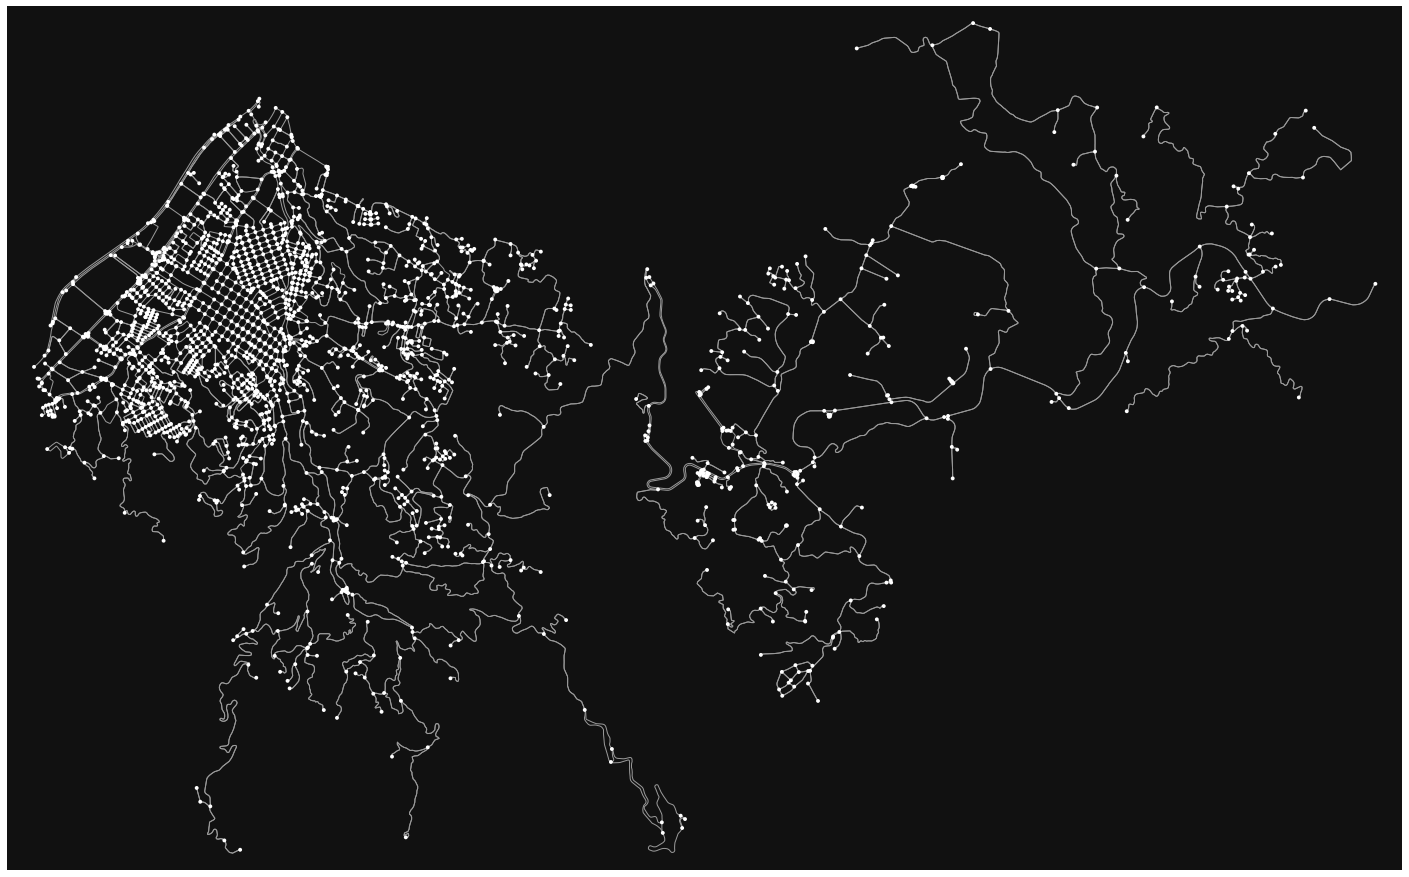

(<Figure size 1800x1800 with 1 Axes>, <AxesSubplot:>)

In [4]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive')
ox.plot_graph(G,figsize=(25,25))

La función por defecto tiene un parámetro *simplify* puesto en True, por lo que trae un grafo simplificado, con pocos puntos. Como queremos tratar de mostrar el trayecto completo de la ruta vamos a traer más información del mapa y pondremos el parámetro en False.

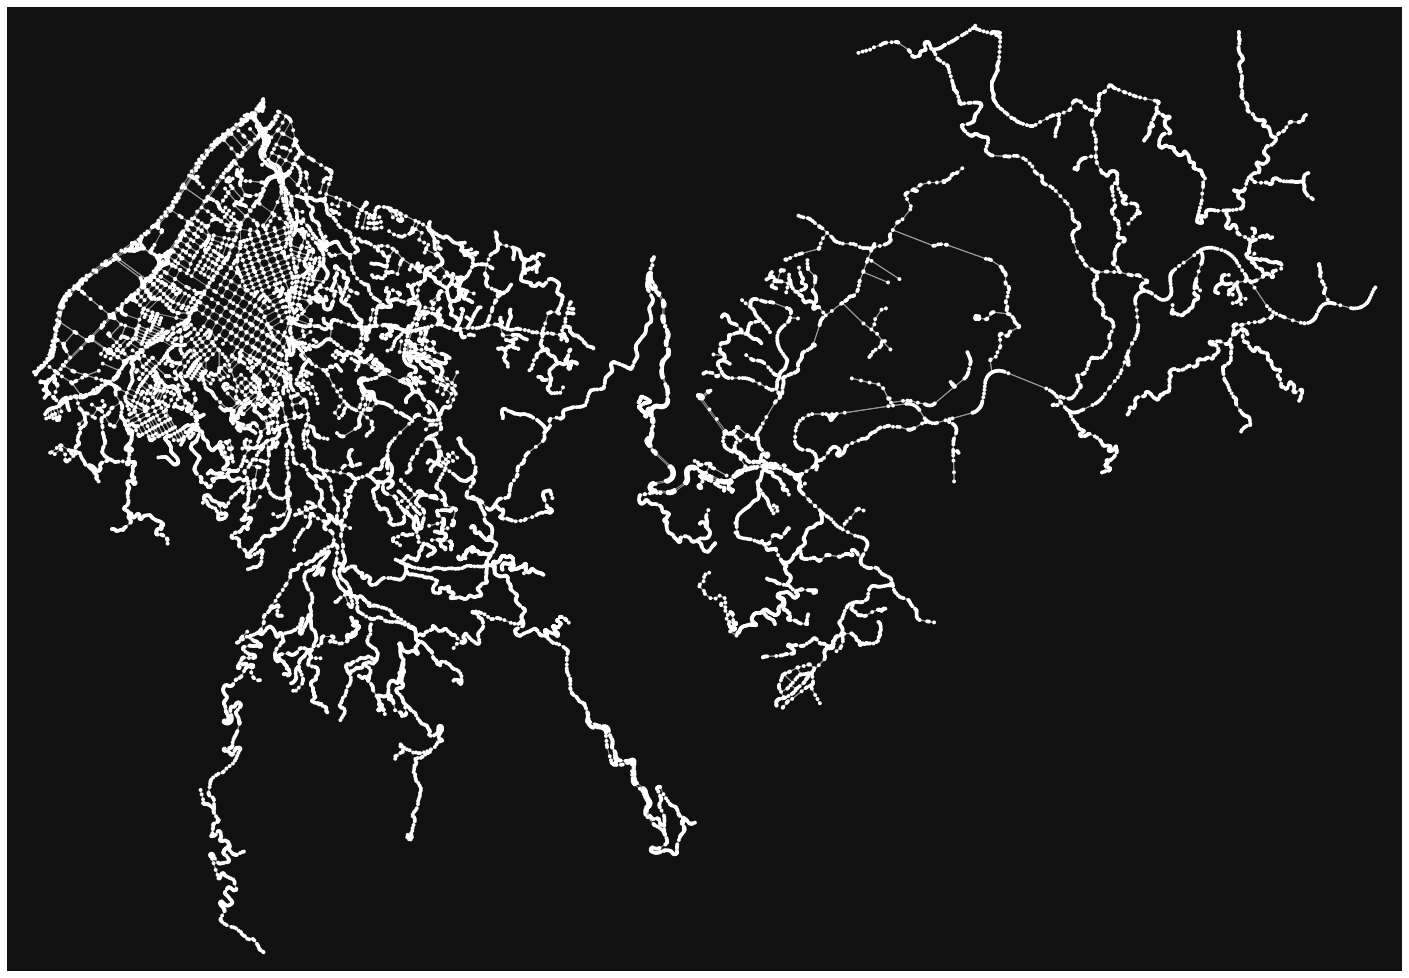

(<Figure size 1800x1800 with 1 Axes>, <AxesSubplot:>)

In [5]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive',simplify=False)
ox.plot_graph(G,figsize=(25,25))

La función *graph_to_gdfs(G)* nos devuelve dos dataframe uno con los nodos y otro con las aristas del grafo.

In [6]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [7]:
gdf_nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
309313450,6.158425,-75.519823,2,NaN,POINT (-75.51982 6.15843)
309313451,6.158399,-75.520285,2,NaN,POINT (-75.52028 6.15840)
309313454,6.159628,-75.521493,2,NaN,POINT (-75.52149 6.15963)
309313455,6.160205,-75.522470,2,NaN,POINT (-75.52247 6.16020)
309313457,6.159977,-75.524408,2,NaN,POINT (-75.52441 6.15998)


In [8]:
gdf_edges.head()

osmid  ...                                           geometry
u         v          key             ...                                                   
309313450 414940715  0    547527416  ...  LINESTRING (-75.51982 6.15843, -75.52004 6.15839)
          440765240  0    547527416  ...  LINESTRING (-75.51982 6.15843, -75.51903 6.15866)
309313451 414940727  0    547527416  ...  LINESTRING (-75.52028 6.15840, -75.52051 6.15847)
          414940715  0    547527416  ...  LINESTRING (-75.52028 6.15840, -75.52004 6.15839)
309313454 4124260034 0    547527418  ...  LINESTRING (-75.52149 6.15963, -75.52164 6.15980)

[5 rows x 13 columns]

Si observamos una parte del dataframe de las aristas, podemos ver que tenemos toda la información donde *u* es el nodo de partida, *v* el nodo de destino en cada uno de las conecciones de los puntos, tenemos el nombre del lugar o calle (name), el tipo de carretera (highway), la máxima velocidad en ese lugar (maxspeed), pero esta variable tiene varios nulos, para poder calcular tiempo en recurrido necesitamos llenar estos campos vacíos. 

Podemos crear una variable speed_kph que se completa con los valores maxspeed y rellena los vacíos, por defecto, la función add_edge_speeds(G) rellena los vacíos con el promedio de ese tipo de carretera, en el mapa, pero podemos también pasarle unos valores fijos, como se hizo anteriormente.

Adicionar una columna con velocidad (**speed_kph**), a partir de la maxspeed que hay

Adicionar otra columna con el tiempo de viaje (**travel_time**)

In [9]:
#G = ox.add_edge_speeds(G)
# Para que en vez del promedio del tipo de vía, ponga uno específico como esté null
hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}
G = ox.add_edge_speeds(G,hwy_speeds)              
G = ox.add_edge_travel_times(G)
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [10]:
gdf_edges[150:200]

osmid  ...                                           geometry
u         v          key             ...                                                   
330634175 340690368  0     30794379  ...  LINESTRING (-75.58981 6.17212, -75.58944 6.17275)
          3270683213 0    551505950  ...  LINESTRING (-75.58981 6.17212, -75.59026 6.17239)
330634176 1657886267 0     30679356  ...  LINESTRING (-75.58825 6.17112, -75.58781 6.17177)
          5919405591 0    577291255  ...  LINESTRING (-75.58825 6.17112, -75.58833 6.17117)
330634179 340690672  0     30028937  ...  LINESTRING (-75.58695 6.17024, -75.58653 6.17099)
          330645156  0    577291255  ...  LINESTRING (-75.58695 6.17024, -75.58752 6.17063)
330634181 8895905673 0    123730430  ...  LINESTRING (-75.58550 6.16934, -75.58589 6.16872)
          5534528338 0    577258425  ...  LINESTRING (-75.58550 6.16934, -75.58591 6.16960)
330634666 1378816147 0    297281673  ...  LINESTRING (-75.58485 6.16893, -75.58435 6.16966)
          330634181  0    577258425  ...  LINESTRING (-75.58485 6.16893, -75.58550 6.16934)
330634667 8895905676 0    123728026  ...  LINESTRING (-75.58432 6.16859, -75.58471 6.16798)
          330634666  0    577258425  ...  LINESTRING (-75.58432 6.16859, -75.58485 6.16893)
330634668 1378816149 0    123728030  ...  LINESTRING (-75.58377 6.16823, -75.58333 6.16890)
          330634667  0    577258425  ...  LINESTRING (-75.58377 6.16823, -75.58432 6.16859)
330634669 330634993  0    123728031  ...  LINESTRING (-75.58326 6.16790, -75.58367 6.16730)
          5534334357 0    351458389  ...  LINESTRING (-75.58326 6.16790, -75.58355 6.16809)
330634981 3572367343 0    351458388  ...  LINESTRING (-75.58037 6.16602, -75.58042 6.16606)
330634987 3572367372 0    389248617  ...  LINESTRING (-75.58082 6.16494, -75.58087 6.16475)
          5529679663 0    576533571  ...  LINESTRING (-75.58082 6.16494, -75.58075 6.16486)
330634988 1378816158 0    123728027  ...  LINESTRING (-75.58120 6.16549, -75.58080 6.16612)
          5529679694 0    577255132  ...  LINESTRING (-75.58120 6.16549, -75.58099 6.16518)
330634990 1378816113 0    567178182  ...  LINESTRING (-75.58211 6.16626, -75.58169 6.16691)
          3924033388 0    577255133  ...  LINESTRING (-75.58211 6.16626, -75.58187 6.16612)
330634991 1378816118 0    123728029  ...  LINESTRING (-75.58265 6.16657, -75.58309 6.16589)
          5529679699 0    576533587  ...  LINESTRING (-75.58265 6.16657, -75.58237 6.16641)
330634992 1378853843 0    123730028  ...  LINESTRING (-75.58315 6.16697, -75.58276 6.16759)
          5529679700 0    576533588  ...  LINESTRING (-75.58315 6.16697, -75.58268 6.16665)
330634993 5529679696 0    123728031  ...  LINESTRING (-75.58367 6.16730, -75.58372 6.16723)
          330634992  0    576533588  ...  LINESTRING (-75.58367 6.16730, -75.58315 6.16697)
330634994 8895905677 0    123728030  ...  LINESTRING (-75.58420 6.16760, -75.58417 6.16764)
          5529679701 0    576533588  ...  LINESTRING (-75.58420 6.16760, -75.58407 6.16755)
          5529679698 0    576533589  ...  LINESTRING (-75.58420 6.16760, -75.58418 6.16751)
330634995 1378816116 0    123728026  ...  LINESTRING (-75.58473 6.16794, -75.58517 6.16725)
          5529679702 0    906423565  ...  LINESTRING (-75.58473 6.16794, -75.58437 6.16771)
330634997 8895905674 0    297281673  ...  LINESTRING (-75.58529 6.16829, -75.58525 6.16834)
          330634995  0    576533591  ...  LINESTRING (-75.58529 6.16829, -75.58473 6.16794)
330634999 8895905678 0    154884791  ...  LINESTRING (-75.58664 6.16915, -75.58662 6.16919)
          5534301826 0    577255130  ...  LINESTRING (-75.58664 6.16915, -75.58610 6.16881)
330635000 1194445107 0    128396692  ...  LINESTRING (-75.58734 6.16960, -75.58780 6.16889)
          330634999  0    577255130  ...  LINESTRING (-75.58734 6.16960, -75.58664 6.16915)
330635001 330635000  0    576112578  ...  LINESTRING (-75.58791 6.16997, -75.58734 6.16960)
330636751 3576471550 0    935662832  ...  LINESTRING (-75.58305 6.18496, -

In [11]:
gdf_edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
living_street,26.6,44.6,2.2
primary,26.9,50.3,2.0
primary_link,8.5,30.0,1.0
residential,20.9,34.8,2.2
secondary,23.6,48.1,1.8
secondary_link,7.4,30.0,0.9
tertiary,24.1,57.0,1.6
tertiary_link,8.1,44.6,0.6
trunk,45.2,78.0,2.1


Si necesitamos buscar latitudes y longitudes de lugares específicos para buscar en un mapa podemos usar el biblioteca geopy que con Nominatim que nos permite hacerlo gratis

## Ejemplo de mostrar una ruta

In [19]:
import geopy
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent='myGeocoder')

Acá busco la longitud y latitud de la Sede de posgrados de la EIA y la sede de Palmas. Esto devuelve una variable que tiene la dirección completa y la longitud y latitud

In [ ]:
!pip install geocoder

In [30]:
location_start = locator.geocode('Sede Posgrados EIA, Envigado, Colombia')
print(location_start.address)
#location_end=locator.geocode('Universidad EIA, Envigado, Antioquia, Colombia')

Sede Posgrados EIA, Calle 25 Sur, La Magnolia, Envigado, Valle de Aburrá, Antioquia, Región Andina, 3549090, Colombia


In [31]:
location_end=locator.geocode('Escuela de Ingeniería de Antioquia,Antioquia,Colombia')
print(location_end.address)

Escuela de Ingeniería de Antioquia, km 2+200, Vía Acceso P. Palmitas, Envigado, Valle de Aburrá, Antioquia, Región Andina, 055420, Colombia


In [32]:
print((location_start.latitude, location_start.longitude))
print((location_end.latitude, location_end.longitude))

(6.1789229, -75.57947803842347)
(6.15696005, -75.51685480358233)


Como un ejemplo de mostrar una ruta en el mapa vamos a usar la biblioteca nx con la función ***shortest_path*** que recibe un grafo de mapa, un punto de origen y uno de destino y según un peso, en este caso tiempo (por la columna *travel_time*), busca una ruta utilizando el algoritmo *dijkstra*.

Con la función ***plot_graph_route*** de ox se puede dibujar una ruta, se le debe pasar una lista de la ruta con los códigos de los nodos del grafo a dibujar en la ruta.

In [35]:
start= (location_start.latitude, location_start.longitude)
end= (location_end.latitude, location_end.longitude)
start_node = ox.distance.nearest_nodes(G, start[1],start[0]) 
end_node = ox.distance.nearest_nodes(G, end[1],end[0])
route1 = nx.shortest_path(G, start_node, end_node, weight='travel_time')
print(route1)

[3648102725, 340686744, 340686745, 340686746, 4404924419, 4404924420, 340686060, 4404924418, 4404924417, 3648101524, 340686059, 4404924394, 3648101523, 3648101522, 4404924400, 4404924399, 4404924397, 4404924395, 3648102740, 338172930, 3648102733, 4404924390, 338172929, 3648101520, 4404924284, 338172928, 338172927, 3572367329, 7115606670, 338172926, 340685471, 1841397085, 1841397172, 1841397053, 1841397105, 1841397060, 1841397113, 1841397024, 1841397145, 2218640191, 1841397160, 1841397062, 3572367314, 1841397088, 1841397063, 1841397076, 3572367298, 3572367297, 1841397051, 1841397166, 1841397147, 3924033541, 1841397219, 1841397091, 1841397044, 1841397150, 1841397151, 1841397176, 1841397027, 6811634117, 1841397030, 1841397035, 1841397148, 6811634116, 1841397103, 6136232307, 1841397058, 1841397083, 6136232308, 1841397123, 1841397110, 1841397118, 1841397115, 6136120669, 3572367313, 3572367312, 1841397168, 1841397144, 6136120668, 6136120670, 1841397149, 1841397081, 1841397121, 1841397056, 18

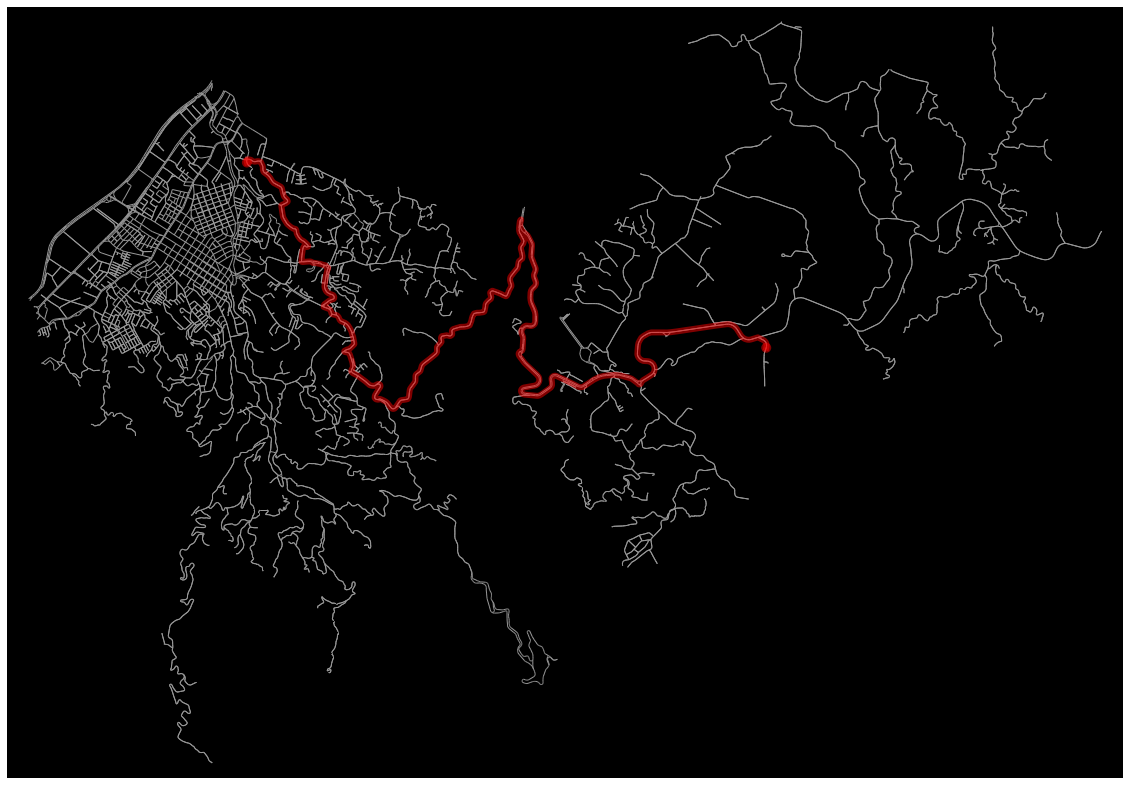

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [36]:
ox.plot_graph_route(G, route1, route_linewidth=6, node_size=0, bgcolor='k',figsize=(20, 20))

Podemos hacer el mismo ejemplo buscando otra ruta pero ahora por distancia (en este caso usaríamos como peso la columna *length*)

In [37]:
route2 = nx.shortest_path(G, start_node, end_node, weight='length')

Comparar las dos rutas

In [38]:
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'travel_time')))
print('Ruta 1 tiene', route1_length, 'metros y toma', route1_time, 'segundos.')
print('Ruta 2 tiene', route2_length, 'metros y toma', route2_time, 'segundos.')

Ruta 1 tiene 15912 metros y toma 1267 segundos.
Ruta 2 tiene 15104 metros y toma 1422 segundos.


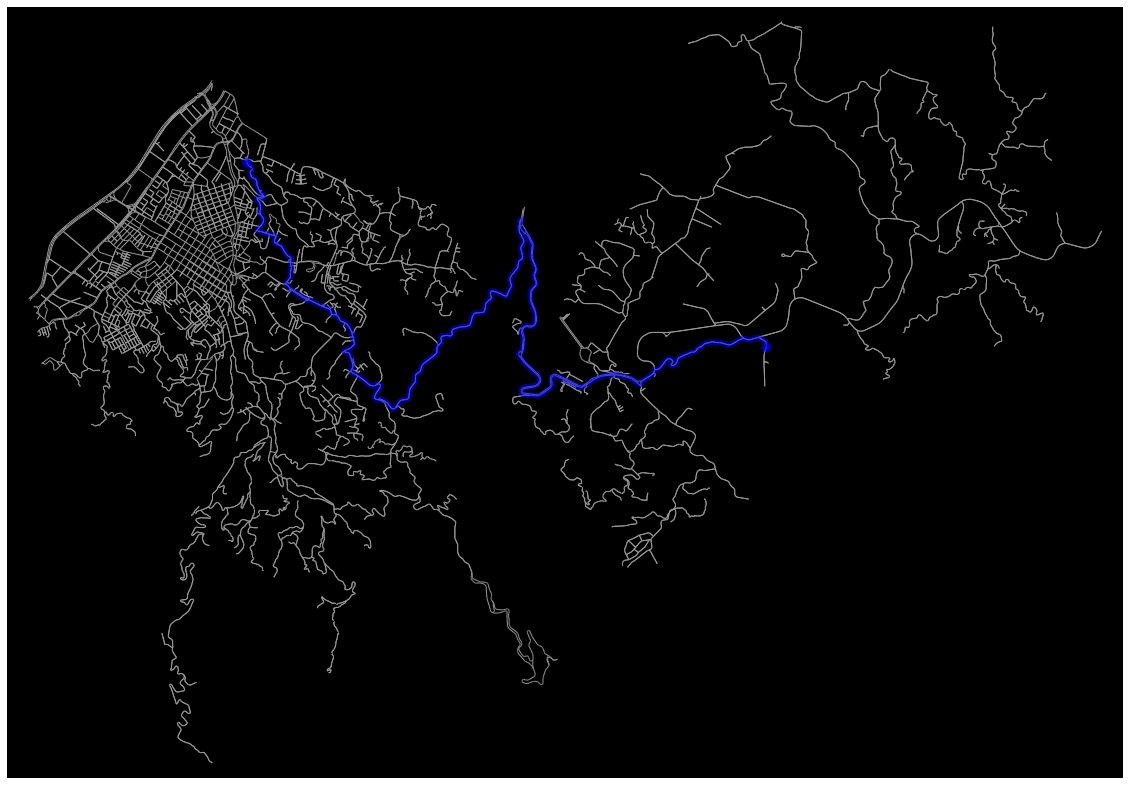

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [40]:
ox.plot_graph_route(G, route2, route_color='b',route_linewidth=6, node_size=0, bgcolor='k',figsize=(20, 20))

## Dataframe geográfico con información del mapa

Podemos crear nuestro propio dataframe con los datos que tenemos en el grafo

In [41]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []

for u, v in zip(route1[:-1], route1[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [42]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length, travel_time)), 
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length", "travel_time"]) 
df.head()

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,3648102725,340686744,-75.579000,6.179068,-75.579032,6.179182,13,1
1,340686744,340686745,-75.579032,6.179182,-75.579025,6.179278,11,1
2,340686745,340686746,-75.579025,6.179278,-75.578987,6.179407,15,2
3,340686746,4404924419,-75.578987,6.179407,-75.578899,6.179438,10,1
4,4404924419,4404924420,-75.578899,6.179438,-75.578847,6.179443,6,1


In [43]:
df.reset_index(inplace=True)
df.head()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,0,3648102725,340686744,-75.579000,6.179068,-75.579032,6.179182,13,1
1,1,340686744,340686745,-75.579032,6.179182,-75.579025,6.179278,11,1
2,2,340686745,340686746,-75.579025,6.179278,-75.578987,6.179407,15,2
3,3,340686746,4404924419,-75.578987,6.179407,-75.578899,6.179438,10,1
4,4,4404924419,4404924420,-75.578899,6.179438,-75.578847,6.179443,6,1


Crear un dataframe geográfico a partir de este para poder tneer las longitudes y latitudes comp puntos geométricos

In [44]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')

In [53]:
gdf.tail()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to,line
784,784,4124260023,440765236,-75.518227,6.158228,-75.518110,6.158092,20,3,POINT (-75.51823 6.15823),POINT (-75.5181102 6.1580916),"LINESTRING (-75.5181102 6.1580916, -75.5182269..."
785,785,440765236,440765235,-75.518110,6.158092,-75.518046,6.157947,18,3,POINT (-75.51811 6.15809),POINT (-75.5180458 6.1579475),"LINESTRING (-75.5180458 6.1579475, -75.5181102..."
786,786,440765235,4124260016,-75.518046,6.157947,-75.518011,6.157794,17,3,POINT (-75.51805 6.15795),POINT (-75.51801089999999 6.1577942),"LINESTRING (-75.51801089999999 6.1577942, -75...."
787,787,4124260016,440765234,-75.518011,6.157794,-75.518019,6.157611,20,3,POINT (-75.51801 6.15779),POINT (-75.518019 6.1576115),"LINESTRING (-75.518019 6.1576115, -75.51801089..."
788,788,440765234,440765233,-75.518019,6.157611,-75.518052,6.157457,18,3,POINT (-75.51802 6.15761),POINT (-75.5180525 6.1574569),"LINESTRING (-75.5180525 6.1574569, -75.518019 ..."


In [54]:
start = gdf[df["node_start"] == start_node]
end = gdf[df["node_end"] == end_node]

In [55]:
start

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to,line
0,0,3648102725,340686744,-75.579,6.179068,-75.579032,6.179182,13,1,POINT (-75.57900 6.17907),POINT (-75.5790318 6.179182),"LINESTRING (-75.5790318 6.179182, -75.5789997 ..."


In [56]:
end

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time,geometry,geometry_to,line
788,788,440765234,440765233,-75.518019,6.157611,-75.518052,6.157457,18,3,POINT (-75.51802 6.15761),POINT (-75.5180525 6.1574569),"LINESTRING (-75.5180525 6.1574569, -75.518019 ..."


## Diferentes formas de visualización en otros mapas

Mapbox requiere access token para algunas visualizaciones como:

'basic', 'streets', 'outdoors', 'light', 'dark', 'satellite', 'satellite- streets'

Sin embargo hay otros mapbox_style que no requieren access token como:

'open-street-map', 'white-bg', 'carto-positron', 'carto-darkmatter', 'stamen- terrain', 'stamen-toner', 'stamen-watercolor'

In [69]:
px.scatter_mapbox(gdf, lon= "X_from", lat="Y_from", zoom=12,mapbox_style='stamen-terrain')

In [64]:
fig = px.scatter_mapbox(gdf, lon= "X_from", lat="Y_from", width=800, height=400, zoom=12,mapbox_style='open-street-map')
fig.add_trace(px.line_mapbox(gdf, lon= "X_from", lat="Y_from").data[0])

In [59]:
fig = px.scatter_mapbox(gdf, lon= "X_from", lat="Y_from", zoom=12, width=1000, height=600, animation_frame="index",mapbox_style='open-street-map')
fig.data[0].marker = dict(size = 12, color="black")
fig.add_trace(px.scatter_mapbox(start, lon= "X_from", lat="Y_from").data[0])
fig.data[1].marker = dict(size = 15, color="red")
fig.add_trace(px.scatter_mapbox(end, lon= "X_from", lat="Y_from").data[0])
fig.data[2].marker = dict(size = 15, color="green")
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])
fig

In [60]:
#graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2) 
route_graph_map = ox.plot_route_folium(G, route1,popup_attribute='name', edge_width=2) 
route_graph_map.save('route.html')

In [61]:
display(route_graph_map)